#  SGmarkets ROTB (Basic Demo)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime as dt
import numpy as np
import pandas as pd

from IPython.display import display
from pandas.tseries.offsets import BDay

from sgmarkets_api_auth import Api
from sgmarkets_plot import Plot
import sgmarkets_api_analytics_rotb as ROTB

from sgmarkets_api_auth.util import topickle, unpickle
import sgmarkets_api_analytics_rotb.biz as biz

%matplotlib inline

<IPython.core.display.Javascript object>

## 0 - Contacts

In [3]:
ROTB.info()


## Swagger

+ ROTB: [Rates Option Trade Builder V1 API](https://analytics-api.sgmarkets.com/rotb/swagger/ui/index)

## Contacts

### Research

+ KURPIEL Adam MarkGrsRfcRat  
Adam.KURPIEL@sgcib.com  
+33 1 42 13 63 42

+ FERRET Kevin MarkDir  
kevin.ferret@sgcib.com  
+44 20 7676 7073

+ BRAIZINHA Bruno MarkGrsRat  
bruno.braizinha@sgcib.com  
+44 20 7676 7073

+ UNGARI Sandrine MarkGrsStgCaq  
sandrine.ungari@sgcib.com  
+44 20 7762 5214

### Python

+ FERRET Kevin MarkDir  
kevin.ferret@sgcib.com  
+44 20 7676 7073

+ BORDERIES Olivier GbisCdo  
olivier.borderies@sgcib.com  
+33 1 42 13 61 04

### Sales

+ AUGIER Cesar MarkFicSlsRatGmo  
Cesar.augier@sgcib.com  
+44 20 7676 7758

+ CARUSO Alessandro MarkFicSlsRatGmo  
alessandro.caruso@sgcib.com  
+44 20 7676 7992

+ SJOENTOFT Emil MarkFicSlsRatNor  
emil.sjoentoft@sgcib.com  
+44 20 7676 5456

+ UNTERSPERGER Alexander MarkFicSlsRatGer  
alexander.untersperger@sgcib.com  
+44 20 7676 7451

+ GHULAMALI Naeem MarkFicSlsRatUki  
naeem.ghulamali@sgcib.com  
+44 20 7676 7321

### IT & API

+ CARISTAN Aurelien MarkAsiDir  
aurelien.caristan@sgcib.com  
+81 3 6777 8016

+ RIVET Nicolas GbisCdo  
nicolas.rivet@sgcib.com  
+33 1 57 29 04 58


## 1 - Authentication

In [4]:
a = Api(verbose=True)

Variables in /Users/Olivier/my_secret.txt
SG_LOGIN=o********************m
SG_PASSWORD=m***************************d
PROXY_LOGIN=m****************n
PROXY_PASSWORD=m********d
PROXY_HOST=m********************t
PROXY_PORT=9***********************************9
Token endpoint: https://login.sgmarkets.com/richclient/gettoken
proxies: {}
Access token {b102****************************532e} loaded from file /Users/Olivier/my_token.txt


## 2 - Request

In [4]:
ep = ROTB.endpoint.v1_compute_strategy_components
rq = ep.request()
start=dt.date.today()-dt.timedelta(days=366)
end=dt.date.today()-dt.timedelta(days=50)

rq.errorMode = 'Full'
rq.startDate = start.strftime('%Y-%m-%d')
rq.endDate = end.strftime('%Y-%m-%d')


rq.weighting = 'DV01'


rq.curve = 'EUR EURIBOR 6M'
rq.expiry = '1M,2M,3M,6M,1Y,2Y,3Y,4Y,5Y,7Y,10Y,15Y,20Y,30Y'
rq.tenor = '1Y,2Y,3Y,4Y,5Y,7Y,10Y,15Y,20Y,30Y'
rq.strike= '@0bp'
rq.type = 'receiver'
rq.settlement = 'cash'
rq.pricingStrategy = 'Auto'
rq.nominal = int(1e6)
rq.strategyWeight = 1

rq.expand()

**<span style="color:black;">INFO</span> -** Your request contains 140 prices over 219 dates i.e. total 30660 prices.

**<span style="color:red;">WARNING</span> -** Your request will be split in 73 chunks to avoid API timeout.

## 3.1 - Make request and save response to disk

In [5]:
res1 = rq.call_api(a)
topickle('ROTB_Notebook_Client_101.pk', res1)

# calling API...
# chunk 1/73 done in 9.57 s
# chunk 2/73 done in 18.01 s
# ...
# chunk 72/73 done in 642.23 s
# chunk 73/73 done in 652.53 s


## 3.2 - Load data from disk

In [6]:
res1 = unpickle('ROTB_Notebook_Client_101.pk')
res1.df_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31360 entries, 0 to 31359
Data columns (total 28 columns):
curve               31360 non-null object
expiry              31360 non-null object
nominal             31360 non-null int64
pricingStrategy     31360 non-null object
settlement          31360 non-null object
strategyWeight      31360 non-null int64
strike              31360 non-null object
tenor               31360 non-null object
type                31360 non-null object
date                31360 non-null datetime64[ns]
adjustmentWeight    31220 non-null float64
breakevenGap        31220 non-null float64
breakevenRate       31220 non-null float64
calibrationDate     31220 non-null object
delta               31220 non-null float64
dv01                31220 non-null float64
error               140 non-null object
forwardRate         31220 non-null float64
gamma               31220 non-null float64
nominal             31220 non-null float64
premiumForward      31220 non-null floa

## 4 - Utilities

In [7]:
def shift_date(end_dt, shift):
    if shift.upper()=='LAST CLOSE' or shift.upper()=='LAST':
        return end_dt
    if 'W' in shift:
        n = shift.replace('W','')
        days = int(n)*5
    elif 'M' in shift:
        n = shift.replace('M','')
        days = int(n)*21
    elif 'Y' in shift:
        n=shift.replace('Y','')
        days = int(n)*252
    elif 'D' in shift:
        n = shift.replace('D','')
        days = int(n)
    return end_dt - BDay(days)  


def nearest_valid_date(date, index):
    if date in index:
        return date
    return index[np.argmin(abs(index - date))]


def build_dic_df_time_diff(multi_frame, end_dt, time_diff, func):
    # Add Max and Min
    dic_df = {}
    for td in time_diff:

        st_dt = shift_date(end_dt, td)
        idx_date = multi_frame.index.get_level_values(1)
        st_dt = nearest_valid_date(st_dt, idx_date)

        if func.upper() == 'D' or func.upper() == 'DIFF':
            dic_df[td] = biz.get_diff(multi_frame, st_dt, end_dt)

        elif func.upper() == 'P' or func.upper() == 'PERCENTILE':
            args = ('date', st_dt, end_dt, 'range')
            dic_df[td] = biz.get_percentile(multi_frame, end_dt, True, args)

        elif func.upper() == 'Z' or func.upper() == 'ZSCORE':
            args = ('date', st_dt, end_dt, 'range')
            dic_df[td] = biz.get_z_score(multi_frame, end_dt, True, args)

        elif func.upper() == 'S' or func.upper() == 'SURFACE':
            dic_df[td] = biz.get_surface(multi_frame, st_dt)

    return dic_df


## 5 - Example Forward Data (3D slice)

In [8]:
# slice the request into a Multindex DataFrame

end_dt = pd.Timestamp.strptime('2017-12-15','%Y-%m-%d')
dic_req_fix = {}
sli = ep.slice(res1, x='expiry', y='date', z='tenor', dic_req_fix=dic_req_fix, value='forwardRate', y_pos='index')

#unit = biz.vol_unit('y')
forward = sli.df_pivot.dropna()*10000#*unit

forward.head(10)

tenor                     1Y         2Y        3Y        4Y         5Y  \
expiry date                                                              
1M     2017-02-06 -20.207677 -13.672654 -4.923222  5.508103  17.554175   
       2017-02-07 -19.830886 -13.053080 -4.299357  6.000863  18.029370   
       2017-02-08 -20.142280 -14.190167 -6.569896  2.821556  14.034409   
       2017-02-09 -19.902522 -13.313456 -5.339251  3.909267  14.795340   
       2017-02-10 -19.749840 -13.099593 -4.979702  4.705816  16.037984   
       2017-02-13 -19.594530 -12.600165 -3.976224  6.167733  17.865415   
       2017-02-14 -19.656846 -12.196657 -3.062764  7.400672  19.327658   
       2017-02-15 -19.601869 -12.314787 -3.426406  6.708360  18.560397   
       2017-02-16 -19.751076 -12.636883 -4.139352  5.729504  17.162774   
       2017-02-17 -19.781632 -13.442293 -5.587614  3.895787  15.119235   

tenor                     7Y        10Y         15Y         20Y         30Y  
expiry date                                                                  
1M     2017-02-06  43.781702  80.648103  119.510257  135.998343  143.928265  
       2017-02-07  43.871027  80.315742  119.184240  135.675352  143.427807  
       2017-02-08  38.896550  74.550432  112.893119  129.168363  136.798914  
       2017-02-09  39.446367  74.711720  112.654382  128.636960  136.066474  
       2017-02-10  41.219480  77.081110  115.703857  132.167367  140.286857  
       2017-02-13  43.543824  80.164551  119.078553  135.805102  144.249017  
       2017-02-14  45.659046  83.193440  122.621408  139.573251  148.144794  
       2017-02-15  44.774869  82.069647  121.877674  139.031952  147.743122  
       2017-02-16  42.768205  79.576529  119.105139  136.173815  145.016762  
       2017-02-17  40.133125  76.479640  115.509960  132.444823  140.950515

### Get the grid

In [9]:
date = end_dt # set the date of the grid
grid = biz.get_surface(forward, end_dt)
grid

tenor,1Y,2Y,3Y,4Y,5Y,7Y,10Y,15Y,20Y,30Y
expiry,,,,,,,,,,
1M,-25.72,-17.36,-4.26,9.31,22.49,47.26,80.33,116.82,133.32,141.61
2M,-24.82,-15.69,-2.42,11.17,24.40,49.25,82.02,118.07,134.24,142.21
3M,-23.93,-14.21,-0.71,12.95,26.19,51.01,83.61,119.22,135.06,142.75
6M,-20.42,-8.80,5.26,19.06,32.26,56.87,88.90,123.03,137.79,144.53
1Y,-11.06,4.35,18.80,32.57,45.39,69.31,99.91,130.86,143.33,148.13
2Y,19.72,33.70,47.03,59.59,71.48,93.83,120.44,145.07,153.39,154.78
3Y,47.65,60.70,72.86,84.58,95.75,116.14,138.53,157.09,161.75,160.36
4Y,73.85,85.63,97.08,108.07,118.61,136.27,154.25,167.10,168.58,164.96
5Y,97.52,108.85,119.73,130.14,139.25,153.78,167.46,175.09,173.92,168.58


### Plot the grid

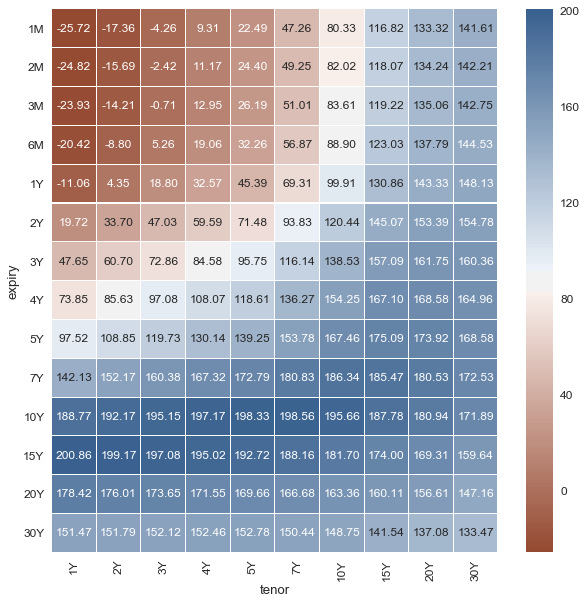

In [10]:
Plot.heatmap(round(grid, 2), figsize=(10, 10), cbar=True, annot=True, annot_kws={'size':12}, fmt='.2f', cmap='SG-RdBu');

### Other functions:

In [11]:
# set a date
from pandas.tseries.offsets import *
date = end_dt-BDay(5)

# get change between two dates
change = biz.get_diff(forward, date, end_dt)
display(change)

# get the max over the entire forward time dimension:
max_= biz.get_max(forward)
display(max_)
# get the max over a range of dates:
args = ('date', date,end_dt, 'range')
max_= biz.get_max(forward, True, args)
display(max_)
# get the max of two dates:
args=('date', date, end_dt)
max_=biz.get_max(forward, True, args)
display(max_)

tenor,1Y,2Y,3Y,4Y,5Y,7Y,10Y,15Y,20Y,30Y
expiry,,,,,,,,,,
1M,0.12,0.28,0.37,0.11,-0.16,-0.94,-2.09,-2.90,-3.71,-4.75
2M,0.16,0.31,0.36,0.10,-0.19,-1.00,-2.13,-2.95,-3.74,-4.77
3M,0.19,0.34,0.35,0.08,-0.22,-1.05,-2.16,-2.98,-3.77,-4.79
6M,0.29,0.41,0.31,0.01,-0.33,-1.23,-2.26,-3.12,-3.86,-4.86
1Y,0.43,0.52,0.15,-0.19,-0.61,-1.63,-2.49,-3.40,-4.06,-5.00
2Y,0.61,0.01,-0.39,-0.87,-1.36,-2.38,-3.00,-3.75,-4.47,-5.29
3Y,-0.59,-0.89,-1.37,-1.87,-2.52,-3.18,-3.55,-4.23,-4.95,-5.60
4Y,-1.19,-1.76,-2.30,-3.03,-3.39,-3.73,-3.94,-4.72,-5.28,-5.87
5Y,-2.35,-2.87,-3.66,-3.96,-4.16,-4.24,-4.48,-5.19,-5.67,-6.12


tenor,1Y,2Y,3Y,4Y,5Y,7Y,10Y,15Y,20Y,30Y
expiry,,,,,,,,,,
1M,-17.59,-6.29,5.38,19.51,34.75,63.57,100.89,139.46,156.03,164.60
2M,-15.86,-4.44,7.35,21.87,37.00,65.95,102.85,140.87,157.07,165.28
3M,-14.10,-2.60,9.30,24.10,39.51,68.26,104.99,142.38,158.15,165.95
6M,-8.55,3.21,15.91,31.58,46.77,75.15,110.96,146.60,161.19,168.05
1Y,3.02,14.99,30.77,46.62,61.65,89.33,123.06,155.04,167.24,172.00
2Y,30.74,46.87,62.66,77.57,91.42,116.98,145.65,170.46,178.33,179.46
3Y,62.91,78.77,93.37,107.06,120.02,142.46,165.81,183.70,187.72,185.68
4Y,95.07,108.99,122.19,134.81,146.37,165.05,182.91,194.58,195.33,190.77
5Y,123.08,135.98,148.42,159.67,169.27,183.95,196.88,202.98,201.11,194.61


tenor,1Y,2Y,3Y,4Y,5Y,7Y,10Y,15Y,20Y,30Y
expiry,,,,,,,,,,
1M,-25.52,-16.95,-3.88,10.13,23.77,49.06,82.73,119.82,137.03,146.37
2M,-24.64,-15.38,-1.99,12.11,25.67,50.99,84.51,121.02,137.98,146.99
3M,-23.72,-13.86,-0.23,13.94,27.50,52.78,86.10,122.20,138.83,147.54
6M,-20.15,-8.39,5.97,20.17,33.72,58.80,91.46,126.15,141.65,149.39
1Y,-10.61,4.71,19.69,33.94,47.04,71.39,102.55,134.27,147.39,153.13
2Y,20.41,35.49,49.36,62.09,74.00,96.49,123.59,148.82,157.86,160.07
3Y,50.41,63.74,75.87,87.81,99.06,119.78,142.42,161.41,166.70,165.96
4Y,77.17,88.76,100.42,111.52,122.26,140.27,158.35,171.83,173.86,170.84
5Y,100.87,112.48,123.47,134.12,143.47,158.09,171.94,180.29,179.58,174.70


tenor,1Y,2Y,3Y,4Y,5Y,7Y,10Y,15Y,20Y,30Y
expiry,,,,,,,,,,
1M,-25.72,-17.36,-4.26,9.31,22.65,48.21,82.42,119.73,137.03,146.37
2M,-24.82,-15.69,-2.42,11.17,24.59,50.25,84.15,121.01,137.98,146.99
3M,-23.93,-14.21,-0.71,12.95,26.41,52.06,85.76,122.20,138.83,147.54
6M,-20.42,-8.80,5.26,19.06,32.59,58.10,91.16,126.15,141.65,149.39
1Y,-11.06,4.35,18.80,32.75,46.00,70.94,102.40,134.27,147.39,153.13
2Y,19.72,33.70,47.42,60.46,72.84,96.21,123.44,148.82,157.86,160.07
3Y,48.24,61.59,74.23,86.44,98.27,119.32,142.08,161.33,166.70,165.96
4Y,75.04,87.39,99.38,111.09,122.00,139.99,158.18,171.83,173.86,170.84
5Y,99.87,111.72,123.39,134.10,143.40,158.02,171.94,180.29,179.58,174.70


In [12]:
# Other function include: Z-score, Min, percentile
args = ('date', date,end_dt, 'range')
zscore = biz.get_z_score(forward, end_dt, True, args)
percentile = biz.get_percentile(forward, end_dt, True, args)
min_ = biz.get_min(forward, True, args)

In [13]:
# All those function could be called via the build_dic_df_time_diff function with relative dates:
zscore = build_dic_df_time_diff(forward, end_dt, ['120D', '8W', '1M', '3M', '1Y'], 'zscore')
#zscore is computed over a 120 days window, 8 weeks window etc...

print(zscore.keys())
zscore['1M']

dict_keys(['120D', '8W', '1M', '3M', '1Y'])


tenor,1Y,2Y,3Y,4Y,5Y,7Y,10Y,15Y,20Y,30Y
expiry,,,,,,,,,,
1M,-0.82,0.02,0.51,0.24,-0.15,-1.00,-1.48,-1.47,-1.54,-1.67
2M,-0.65,0.23,0.46,0.13,-0.21,-0.95,-1.50,-1.47,-1.54,-1.67
3M,-0.69,0.10,0.36,0.04,-0.31,-1.01,-1.47,-1.46,-1.53,-1.66
6M,-0.16,0.35,0.36,0.03,-0.33,-1.08,-1.48,-1.47,-1.54,-1.66
1Y,0.31,0.69,0.33,0.01,-0.43,-1.19,-1.45,-1.45,-1.54,-1.66
2Y,0.84,0.28,-0.16,-0.57,-1.01,-1.43,-1.49,-1.48,-1.58,-1.68
3Y,-0.29,-0.66,-1.01,-1.32,-1.51,-1.60,-1.53,-1.53,-1.61,-1.70
4Y,-0.94,-1.24,-1.47,-1.60,-1.61,-1.60,-1.52,-1.55,-1.61,-1.70
5Y,-1.41,-1.59,-1.65,-1.64,-1.64,-1.56,-1.51,-1.56,-1.63,-1.70


### Resize and select the dataframe

#### on the dates axis

In [14]:
mask=(forward.index.get_level_values('date')>= date) & (forward.index.get_level_values('date') <= end_dt)
new_forward=forward.loc[mask]
new_forward.head(10)

tenor                     1Y         2Y        3Y         4Y         5Y  \
expiry date                                                               
1M     2017-12-08 -25.835834 -17.639168 -4.632157   9.191385  22.648843   
       2017-12-11 -25.810622 -17.674475 -4.946315   8.589555  21.896470   
       2017-12-12 -25.519607 -16.946539 -3.879575  10.049634  23.646595   
       2017-12-13 -25.795046 -17.343037 -4.403680   9.613362  23.217840   
       2017-12-14 -25.805003 -17.347799 -4.071194  10.126179  23.772193   
       2017-12-15 -25.720513 -17.355735 -4.264092   9.306261  22.489149   
2M     2017-12-08 -24.975059 -16.000592 -2.783153  11.068131  24.593141   
       2017-12-11 -24.929928 -16.150760 -3.065086  10.650559  23.937056   
       2017-12-12 -24.635919 -15.377932 -1.991280  12.108816  25.673436   
       2017-12-13 -24.946582 -15.867620 -2.569428  11.426885  25.053741   

tenor                     7Y        10Y         15Y         20Y         30Y  
expiry date                                                                  
1M     2017-12-08  48.207770  82.422546  119.727077  137.034394  146.366505  
       2017-12-11  46.966691  80.321140  117.183240  134.231657  143.399136  
       2017-12-12  49.060323  82.680887  119.500560  136.544768  145.638533  
       2017-12-13  48.791896  82.733574  119.815761  137.002063  146.160102  
       2017-12-14  48.924631  82.379321  119.089161  135.905034  144.668672  
       2017-12-15  47.264688  80.328773  116.822553  133.323910  141.614347  
2M     2017-12-08  50.251780  84.146285  121.012587  137.977161  146.986255  
       2017-12-11  48.901769  82.177486  118.531712  135.186276  144.024068  
       2017-12-12  50.990019  84.509319  120.823604  137.481514  146.253878  
       2017-12-13  50.636404  84.375894  121.021602  137.895568  146.739171

### or use the function

In [15]:
args=('date', date,end_dt, 'range')
new_forward_2 = biz.select_data(forward, args)

all(new_forward)==all(new_forward_2)

True

#### on the expiry axis

In [16]:
mask=(forward.index.get_level_values('expiry')== '1M') | (forward.index.get_level_values('expiry') == '3M')
new_forward_3=forward.loc[mask]

# with function
args=('expiry','1M','3M')
new_forward_4=biz.select_data(forward,args)

display(new_forward_4.head(10))

all(new_forward_3)==all(new_forward_4)

tenor                     1Y         2Y        3Y        4Y         5Y  \
expiry date                                                              
1M     2017-02-06 -20.207677 -13.672654 -4.923222  5.508103  17.554175   
       2017-02-07 -19.830886 -13.053080 -4.299357  6.000863  18.029370   
       2017-02-08 -20.142280 -14.190167 -6.569896  2.821556  14.034409   
       2017-02-09 -19.902522 -13.313456 -5.339251  3.909267  14.795340   
       2017-02-10 -19.749840 -13.099593 -4.979702  4.705816  16.037984   
       2017-02-13 -19.594530 -12.600165 -3.976224  6.167733  17.865415   
       2017-02-14 -19.656846 -12.196657 -3.062764  7.400672  19.327658   
       2017-02-15 -19.601869 -12.314787 -3.426406  6.708360  18.560397   
       2017-02-16 -19.751076 -12.636883 -4.139352  5.729504  17.162774   
       2017-02-17 -19.781632 -13.442293 -5.587614  3.895787  15.119235   

tenor                     7Y        10Y         15Y         20Y         30Y  
expiry date                                                                  
1M     2017-02-06  43.781702  80.648103  119.510257  135.998343  143.928265  
       2017-02-07  43.871027  80.315742  119.184240  135.675352  143.427807  
       2017-02-08  38.896550  74.550432  112.893119  129.168363  136.798914  
       2017-02-09  39.446367  74.711720  112.654382  128.636960  136.066474  
       2017-02-10  41.219480  77.081110  115.703857  132.167367  140.286857  
       2017-02-13  43.543824  80.164551  119.078553  135.805102  144.249017  
       2017-02-14  45.659046  83.193440  122.621408  139.573251  148.144794  
       2017-02-15  44.774869  82.069647  121.877674  139.031952  147.743122  
       2017-02-16  42.768205  79.576529  119.105139  136.173815  145.016762  
       2017-02-17  40.133125  76.479640  115.509960  132.444823  140.950515

True

#### on the tenor axis

In [17]:
new_forward_5=forward[['2Y', '5Y', '10Y', '30Y']]
new_forward_5.head(10)

tenor                     2Y         5Y        10Y         30Y
expiry date                                                   
1M     2017-02-06 -13.672654  17.554175  80.648103  143.928265
       2017-02-07 -13.053080  18.029370  80.315742  143.427807
       2017-02-08 -14.190167  14.034409  74.550432  136.798914
       2017-02-09 -13.313456  14.795340  74.711720  136.066474
       2017-02-10 -13.099593  16.037984  77.081110  140.286857
       2017-02-13 -12.600165  17.865415  80.164551  144.249017
       2017-02-14 -12.196657  19.327658  83.193440  148.144794
       2017-02-15 -12.314787  18.560397  82.069647  147.743122
       2017-02-16 -12.636883  17.162774  79.576529  145.016762
       2017-02-17 -13.442293  15.119235  76.479640  140.950515

## 7 - Example Historical Data (2D Slice)

In [18]:
dic_req_fix = {'tenor': '10Y'}
# use the slicer according to what you are looking for
sli = ep.slice(res1, x='date', y='expiry', dic_req_fix=dic_req_fix, value='forwardRate')

forward_10Y = sli.df_pivot.dropna()*10000#*unit
forward_10Y.head(10)

expiry,1M,2M,3M,6M,1Y,2Y,3Y,4Y,5Y,7Y,10Y,15Y,20Y,30Y
date,,,,,,,,,,,,,,
2017-02-06,80.648103,82.394615,84.318375,89.672961,100.601511,121.888490,141.780034,159.730057,174.592762,194.483982,201.636632,183.841429,164.875989,142.879900
2017-02-07,80.315742,82.094034,83.962883,89.321493,100.271769,121.447799,141.281565,159.079029,173.705045,193.707136,201.178409,183.252013,163.903607,142.380510
2017-02-08,74.550432,76.451460,78.024048,83.204146,93.779961,114.313392,133.912250,151.190154,165.891982,185.877166,193.261200,175.841899,156.730407,135.786868
2017-02-09,74.711720,76.551347,78.148220,83.311871,93.871637,114.420080,133.364955,150.587546,165.175343,184.845639,191.934683,174.408595,155.418833,135.063258
2017-02-10,77.081110,78.895518,80.549113,85.831310,96.744013,117.347325,136.736497,154.259887,169.182565,189.400717,196.997974,179.850708,161.566970,139.601417
2017-02-13,80.164551,81.904644,83.821428,89.153360,100.024215,121.056273,140.841232,158.836859,173.710989,193.894751,201.732196,184.934629,166.572490,143.095149
2017-02-14,83.193440,85.000971,86.900381,92.351417,103.506535,125.067420,145.043754,163.240981,178.436711,198.988943,206.562479,189.571059,170.974112,147.075391
2017-02-15,82.069647,84.087092,85.756440,91.253697,102.467267,123.959261,144.272830,162.238401,177.680878,198.514537,206.625008,189.980186,170.938658,147.200000
2017-02-16,79.576529,81.495332,83.161926,88.554687,99.600900,121.042446,140.845347,158.783647,174.088286,194.991059,203.167851,186.834312,168.420924,144.497084


#### Plot

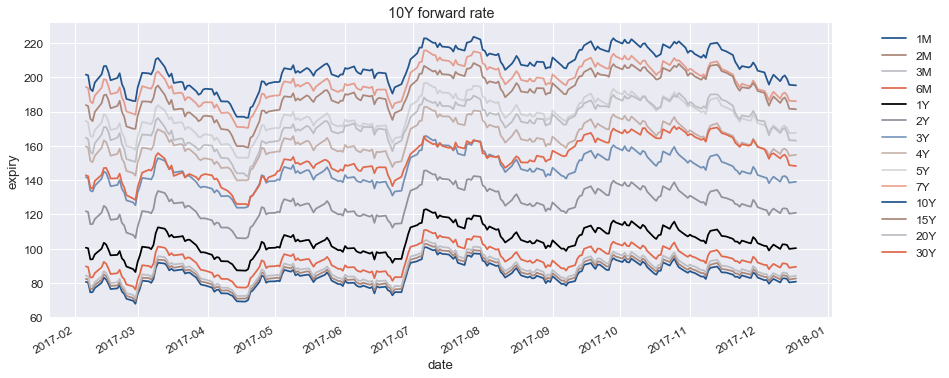

In [19]:
Plot.line(forward_10Y, figsize=(14, 6), title='10Y forward rate')

In [20]:
Plot.highstock(forward_10Y[['1M','3M','6M']], title='10Y forward rate')

<IPython.core.display.Javascript object>

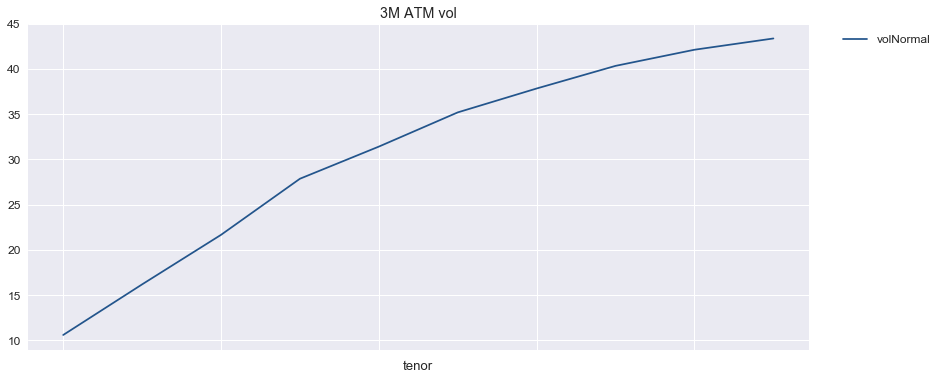

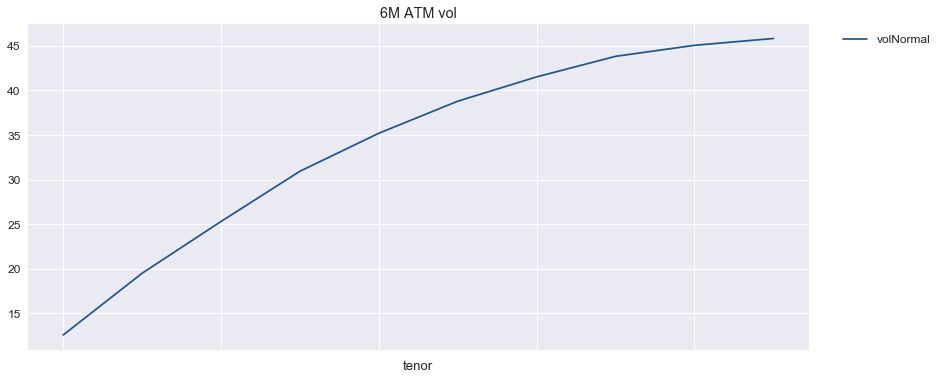

In [21]:
# example of a 2d slice with a fixed date
unit=biz.vol_unit('y')
dic_req_fix = {'date': pd.Timestamp('2017-12-18'), 'expiry': '3M'}
# use the slicer 
v1_1 = ep.slice(res1, x='tenor', dic_req_fix=dic_req_fix, value='volNormal')
dic_req_fix = {'date': pd.Timestamp('2017-12-18'), 'expiry': '6M'}
# use the slicer
v1_2 = ep.slice(res1, x='tenor', dic_req_fix=dic_req_fix, value='volNormal')

Plot.line(v1_1.df_pivot*10000*unit, figsize=(14, 6), title='3M ATM vol')
Plot.line(v1_2.df_pivot*10000*unit, figsize=(14, 6), title='6M ATM vol')

#### another example

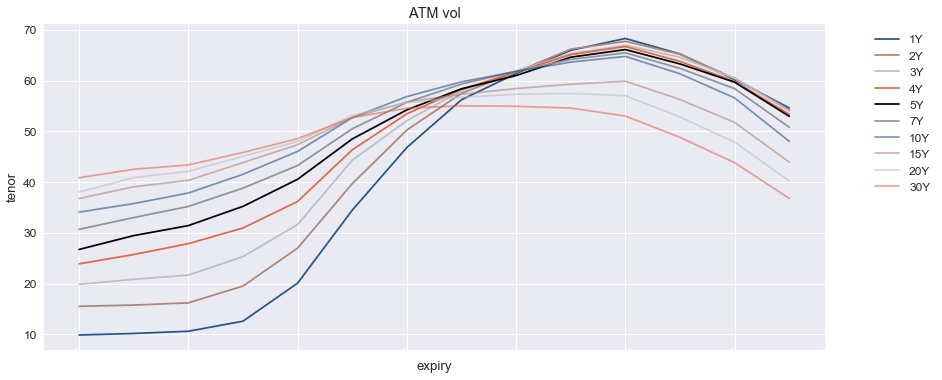

In [22]:
dic_req_fix = {'date': pd.Timestamp('2017-12-18')}
s1 = ep.slice(res1, x='expiry', y='tenor', dic_req_fix=dic_req_fix, value='volNormal')
Plot.line(s1.df_pivot*10000*unit, figsize=(14, 6), title='ATM vol')

#### 3D chart:

In [23]:
dic_req_fix = {'date': pd.Timestamp('2017-12-18')}
s1 = ep.slice(res1, x='expiry', y='tenor', dic_req_fix=dic_req_fix, value='volNormal')
Plot.surface3D(s1.df_pivot, z_label='volNormal', z_round=4)

### Construct spreads and fly

In [24]:
# define spreads:
spread=[
('2Y','5Y'),('2Y','10Y'),('2Y','20Y'),('2Y','30Y'),('5Y','10Y'), \
('5Y','20Y'),('5Y','30Y'),('10Y','20Y'),('10Y','30Y'),('20Y','30Y')]

# use the spread builder function
slope = biz.build_spread(forward, spread,axis='Tenor')
# you could also specified weights:
w=[-1, 1]
slope2=biz.build_spread(forward, spread, 'T', w)

print(all(slope)==all(slope2))
slope2.head(10)

spread - weight len mismatch by default spread weighted (-1,1)
True


2Y5Y      2Y10Y       2Y20Y       2Y30Y      5Y10Y  \
expiry date                                                                  
1M     2017-02-06  31.226830  94.320757  149.670997  157.600920  63.093927   
       2017-02-07  31.082449  93.368822  148.728431  156.480887  62.286373   
       2017-02-08  28.224576  88.740599  143.358531  150.989081  60.516024   
       2017-02-09  28.108796  88.025177  141.950416  149.379931  59.916381   
       2017-02-10  29.137577  90.180703  145.266960  153.386450  61.043125   
       2017-02-13  30.465580  92.764716  148.405268  156.849183  62.299136   
       2017-02-14  31.524314  95.390097  151.769908  160.341450  63.865783   
       2017-02-15  30.875184  94.384433  151.346739  160.057909  63.509250   
       2017-02-16  29.799657  92.213412  148.810698  157.653645  62.413755   
       2017-02-17  28.561528  89.921933  145.887116  154.392808  61.360405   

                        5Y20Y       5Y30Y     10Y20Y     10Y30Y    20Y30Y  
expiry date                                                                
1M     2017-02-06  118.444167  126.374090  55.350240  63.280163  7.929922  
       2017-02-07  117.645982  125.398438  55.359609  63.112065  7.752456  
       2017-02-08  115.133955  122.764505  54.617931  62.248481  7.630550  
       2017-02-09  113.841620  121.271135  53.925239  61.354754  7.429515  
       2017-02-10  116.129382  124.248873  55.086257  63.205747  8.119490  
       2017-02-13  117.939688  126.383603  55.640551  64.084466  8.443915  
       2017-02-14  120.245593  128.817136  56.379811  64.951353  8.571543  
       2017-02-15  120.471556  129.182726  56.962306  65.673476  8.711170  
       2017-02-16  119.011041  127.853988  56.597286  65.440233  8.842947  
       2017-02-17  117.325588  125.831280  55.965183  64.470875  8.505692

In [25]:
# It is possible to change the axis to build calendar spread:

spread=[('1M','3M'),('1M','6M'),('3M','6M'),('6M','1Y'), ('1Y','2Y')]

calendar = biz.build_spread(forward, spread, axis='Expiry')

w=[-1,1]
calendar2=biz.build_spread(forward,spread, 'E', w)

print(all(calendar)==all(calendar2))
calendar2.head(10)

spread - weight len mismatch by default spread weighted (-1,1)
True


tenor                    1Y        2Y        3Y        4Y        5Y        7Y  \
expiry date                                                                     
1M3M   2017-02-06  2.198710  2.640785  3.052971  3.501892  3.784143  4.073362   
       2017-02-07  2.297490  2.649668  2.978141  3.505827  3.750959  3.977812   
       2017-02-08  1.996211  2.279571  2.653646  3.180205  3.441232  3.711001   
       2017-02-09  2.151155  2.390598  2.776265  3.138529  3.415350  3.643762   
       2017-02-10  2.124001  2.431222  2.833419  3.207540  3.481649  3.737410   
       2017-02-13  2.347737  2.681247  3.035962  3.450839  3.735693  4.026501   
       2017-02-14  2.411496  2.765315  3.060904  3.527708  3.815683  4.062724   
       2017-02-15  2.350546  2.673748  2.959682  3.457456  3.714934  3.964796   
       2017-02-16  2.242806  2.519178  2.944908  3.303622  3.571200  3.819899   
       2017-02-17  2.036903  2.343477  2.754820  3.147602  3.446848  3.728412   

tenor                   10Y       15Y       20Y       30Y  
expiry date                                                
1M3M   2017-02-06  3.670272  2.617221  1.852863  1.195167  
       2017-02-07  3.647141  2.578563  1.806312  1.172852  
       2017-02-08  3.473616  2.472014  1.714894  1.093943  
       2017-02-09  3.436500  2.444099  1.725861  1.096773  
       2017-02-10  3.468003  2.460214  1.746217  1.119712  
       2017-02-13  3.656878  2.608629  1.864374  1.193949  
       2017-02-14  3.706940  2.636825  1.864583  1.209243  
       2017-02-15  3.686793  2.607125  1.846908  1.186294  
       2017-02-16  3.585397  2.560737  1.834112  1.167403  
       2017-02-17  3.468595  2.476204  1.764519  1.128352

In [26]:
# The function is the same for fly but kwargs need to be passed:

spread=[
('2Y','5Y','10Y'),('2Y','7Y','10Y'),('2Y','5Y','30Y'), \
('2Y','10Y','30Y'), ('5Y','7Y','10Y'),('5Y','10Y','30Y'), \
('7Y','10Y','20Y'),('7Y','10Y','30Y'),('10Y','20Y','30Y')]

kwargs={'type':'Fly'}
fly=biz.build_spread(forward,spread, 'Tenor', kwargs=kwargs) # by default w=[-1,2,-1] long belly

kwargs={'type':'Fly'}
fly2=biz.build_spread(forward, spread, 'Tenor', [-1,2,-1], kwargs=kwargs)
all(fly)==all(fly2)

fly.head(10)

fly - weight len mismatch by default fly weighted (-1,2,-1)


2Y5Y10Y    2Y7Y10Y    2Y5Y30Y   2Y10Y30Y    5Y7Y10Y  \
expiry date                                                                
1M     2017-02-06 -31.867098  20.587956 -95.147260  31.040595 -10.638873   
       2017-02-07 -31.203923  20.479392 -94.315989  30.256757 -10.603057   
       2017-02-08 -32.291448  17.432834 -94.539929  26.492118 -10.791741   
       2017-02-09 -31.807585  17.494470 -93.162339  26.670422 -10.614325   
       2017-02-10 -31.905548  18.457444 -95.111295  26.974955 -10.680134   
       2017-02-13 -31.833556  19.523263 -95.918023  28.680250 -10.942317   
       2017-02-14 -32.341468  20.321309 -97.292821  30.438744 -11.203006   
       2017-02-15 -32.634066  19.794878 -98.307542  28.710958 -11.080306   
       2017-02-16 -32.614098  18.596765 -98.054331  26.773179 -11.202892   
       2017-02-17 -32.798877  17.228903 -97.269752  25.451058 -11.332625   

                   5Y10Y30Y   7Y10Y20Y   7Y10Y30Y  10Y20Y30Y  
expiry date                                                   
1M     2017-02-06 -0.186235 -18.483840 -26.413762  47.420318  
       2017-02-07 -0.825692 -18.914895 -26.667350  47.607154  
       2017-02-08 -1.732458 -18.964049 -26.594599  46.987381  
       2017-02-09 -1.438373 -18.659886 -26.089401  46.495725  
       2017-02-10 -2.162622 -19.224628 -27.344118  46.966767  
       2017-02-13 -1.785330 -19.019825 -27.463740  47.196637  
       2017-02-14 -1.085571 -18.845416 -27.416959  47.808268  
       2017-02-15 -2.164226 -19.667528 -28.378698  48.251136  
       2017-02-16 -3.026478 -19.788962 -28.631909  47.754339  
       2017-02-17 -3.110470 -19.618668 -28.124360  47.459491

In [27]:
# all the desciptive stat functions could be used on multindex dataframe and so on spreads and flyes.

args=('date', date, end_dt, 'range')
zscore_fly = biz.get_z_score(fly, end_dt, True, args)
zscore_fly

,2Y5Y10Y,2Y7Y10Y,2Y5Y30Y,2Y10Y30Y,5Y7Y10Y,5Y10Y30Y,7Y10Y20Y,7Y10Y30Y,10Y20Y30Y
expiry,,,,,,,,,
1M,0.83,-0.79,1.45,0.04,0.43,1.34,1.52,1.85,-0.91
2M,0.66,-0.73,1.37,-0.21,1.92,1.42,1.11,1.80,-0.68
3M,0.67,-0.85,1.39,-0.20,1.82,1.44,1.21,1.76,-0.72
6M,0.51,-1.19,1.34,-0.33,1.29,1.41,1.45,1.81,-0.75
1Y,0.06,-1.78,1.27,-0.69,-0.78,1.47,1.38,1.76,-0.96
2Y,-0.57,-1.66,1.33,-0.63,-0.73,1.76,1.63,1.78,-1.17
3Y,-0.72,-1.15,2.00,0.31,-1.50,1.83,1.85,1.88,-1.04
4Y,-0.68,-1.22,2.18,0.87,-0.86,1.87,1.97,1.98,-1.44
5Y,-1.37,-1.25,1.69,1.33,0.83,2.06,2.03,2.02,-1.76
